In [6]:
import sys
sys.path.append('../')

# imports
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras as k
from tensorflow.keras import layers, models
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from encoder.binding_2D_matrix_encoder import binding_encoding
# from miRBench.encoder import miRBindEncoder



# parameters
training_file_path = '../datasets/training/train_set_1_20_CLASH2013_paper.tsv'

alphabet = {"AT": 1., "TA": 1., "GC": 1., "CG": 1., "AU": 1., "UA": 1.}
input_shape = (50, 20, 1)  # shape of the input image
learning_rate = 0.001  # learning rate
epochs = 20  # number of epochs/dataset iterations
batch_size = 32  # batch size
reg_factor = 0.01  # regularization factor
dropout_rate = 0.5  # dropout rate

#### ResBlock Class and Building ResNet function

In [8]:
# defining a custom Keras layer which inturn implements a residual block
@register_keras_serializable()
class ResBlock(layers.Layer):
    """
    Defines a Residual block based on the original ResNet paper.
    The block either maintains the input dimensions or downsamples based on the specified parameters.
    """

    def __init__(self, downsample=False, filters=16, kernel_size=3):
        """
        Initializes the residual block with optional downsampling.
        
        Parameters:
        - downsample: Boolean, whether to downsample the input (using stride of 2)
        - filters: Number of filters for the Conv2D layers
        - kernel_size: Size of the convolution kernel
        """
        # calling the parent class constructor
        super(ResBlock, self).__init__()

        # parameters for the residual block
        self.downsample = downsample
        self.filters = filters
        self.kernel_size = kernel_size

        # initialize first convolution layer, with stride 1 or 2 depending on downsampling
        self.conv1 = layers.Conv2D(kernel_size=self.kernel_size,
                                   strides=(1 if not self.downsample else 2),
                                   filters=self.filters,
                                   padding="same",
                                   kernel_regularizer=L2(reg_factor))
        self.activation1 = layers.ReLU()  # activation function after first convolution
        self.batch_norm1 = layers.BatchNormalization()  # batch normalization after first convolution
        
        # initialize second convolution layer with stride 1 (no downsampling here)
        self.conv2 = layers.Conv2D(kernel_size=self.kernel_size,
                                   strides=1,
                                   filters=self.filters,
                                   padding="same",
                                   kernel_regularizer=L2(reg_factor))

        # third convolution if downsampling is needed to match input dimensions
        if self.downsample:
          self.conv3 = layers.Conv2D(kernel_size=1,
                                     strides=2,
                                     filters=self.filters,
                                     padding="same",
                                     kernel_regularizer=L2(reg_factor))

        self.activation2 = layers.ReLU()  # activation after second convolution
        self.batch_norm2 = layers.BatchNormalization()  # batch normalization after second convolution

    def call(self, inputs):
        """
        Forward pass for the residual block. Applies the convolutions, activation, and adds the skip connection.

        Parameters:
        - inputs: Input tensor

        Returns:
        - Tensor after applying the residual block transformation
        """
        # first convolution, activation, and batch normalization
        x = self.conv1(inputs)
        x = self.activation1(x)
        x = self.batch_norm1(x)
        
        # second convolution (no downsampling here)
        x = self.conv2(x)

        # adjust input dimensions if downsampling
        if self.downsample:
            inputs = self.conv3(inputs)

        # add the input (skip connection) to the output of the convolutions
        x = layers.Add()([inputs, x])

        # final activation and batch normalization
        x = self.activation2(x)
        x = self.batch_norm2(x)

        return x

    def get_config(self):
        """
        Returns the configuration of the residual block (required for saving and loading the model).
        """
        return {'filters': self.filters, 'downsample': self.downsample, 'kernel_size': self.kernel_size}
    
# define the ResNet model
def build_resnet(input_shape):
    """
    Builds a simple ResNet model using custom residual blocks.
    """
    inputs = layers.Input(shape=input_shape)

    # initial Conv Layer
    x = layers.Conv2D(64, kernel_size=(3, 3), padding='same', kernel_regularizer=L2(reg_factor))(inputs)
    x = layers.ReLU()(x)
    x = layers.BatchNormalization()(x)

    # add ResBlocks
    x = ResBlock(filters=64, downsample=False)(x)
    x = ResBlock(filters=64, downsample=False)(x)

    # flatten and add dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=L2(reg_factor))(x)
    x = layers.Dropout(dropout_rate)(x)  # Dropout layer
    x = layers.Dense(1, activation='sigmoid', kernel_regularizer=L2(reg_factor))(x)  # binary classification (0 or 1)

    # build model
    model = models.Model(inputs, x)
    # compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy',metrics=['accuracy'])
    # output model summary
    model.summary()
    
    return model

#### Data Encoding and Building Model

In [10]:
# encode the data using your binding_2D_matrix_encoder's binding_encoding function
def encode_dataset(data, rna_type):
    # use the function from the binding_2D_matrix_encoder module
    return binding_encoding(data, rna_type, alphabet=alphabet)

# load the training dataset
print("----- <Loading Training Dataset> -----")
df_train = pd.read_csv(training_file_path, sep='\t')
print("----- <Dataset Loaded Successfully> -----\n")

# print the dataset shape and first few rows
print(f"Training Dataset shape: {df_train.shape}")
print(f"First few rows of the dataset:\n{df_train.head()}\n")

# Split df_train into actual training and validation sets
training_data, validation_data = train_test_split(df_train, test_size=0.1, random_state=42)
print(f"Size of training set: {len(training_data)}")
print(f"Size of validation set: {len(validation_data)}\n")

print("----- <Encoding Data> -----")
encoded_training_data, training_labels = encode_dataset(training_data, "miRNA")
print("----- <Training Data Encoded Successfully> -----")
encoded_validation_data, validation_labels = encode_dataset(validation_data, "miRNA")
print("----- <Validation Data Encoded Successfully> -----")
print("----- <Successfully Encoded Data> -----\n")
'''Displaying the encoded data'''
# print(f"Encoded training data shape: {encoded_training_data.shape}")
# print(f"Encoded validation data shape: {encoded_validation_data.shape}\n")
# print(f"Encoded testing data shape: {encoded_testing_data.shape}")
# print(f"First encoded training example:\n{encoded_training_data[0]}")
# print(f"First training label: {training_labels[0]}\n")
# print(f"First encoded testing example:\n{encoded_testing_data[0]}")

# build the ResNet model
input_shape = encoded_training_data.shape[1:]  # assuming the encoded data is 4D (samples, height, width, channels)
print("----- <Building Model> -----")
model = build_resnet(input_shape)
print("----- <Model Built Successfully> -----\n")

----- <Loading Training Dataset> -----
----- <Dataset Loaded Successfully> -----

Training Dataset shape: (323232, 3)
First few rows of the dataset:
                  miRNA                                               gene  \
0  TGTAAACATCCTCGACTGGA  GTCGAGAAGTCAACGACTCAATGAAGAATTCCACTTATGGCGTGAA...   
1  TGAGACCTCTGGGTTCTGAG  GACCTCAGAGCTCCAGGATCATCAGTAAATTTGTCATGTTATATAT...   
2  GAGGGTTGGGTGGAGGCTCT  TGCCATAATGAACCGTCCAGCCCCTGTGGAGATCTCCTATGAGAAC...   
3  CAAAGTGCTTACAGTGCAGG  CACCAGAATTGCCAAAGCACATATATAATAAATTAGATAAAGGGCA...   
4  TTAGGGCCCTGGCTCCATCT  AGCCAAGTGGAGAAGGGTTCCTATCCCTGGCAGGTATCTCTGAAAC...   

   label  
0      1  
1      1  
2      1  
3      1  
4      1  

Size of training set: 290908
Size of validation set: 32324

----- <Encoding Data> -----
----- <Training Data Encoded Successfully> -----
----- <Validation Data Encoded Successfully> -----
----- <Successfully Encoded Data> -----

----- <Building Model> -----


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 50, 20, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 50, 20, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 50, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 50, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block_2 (ResBlock)          │ (None, 50, 20, 64)     │        74,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block_3 (ResBlock)          │ (None, 50, 20, 64)     │        74,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    32,768,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,918,657 (125.57 MB)

 Trainable params: 32,918,017 (125.57 MB)

 Non-trainable params: 640 (2.50 KB)

----- <Model Built Successfully> -----



#### Training Model

In [ ]:
# train the model
print("----- <Training Model> -----")
history = model.fit(encoded_training_data, training_labels, epochs=epochs, batch_size=batch_size, 
                    validation_data=(encoded_validation_data, validation_labels))
print("----- <Model Trained Successfully> -----\n")

----- <Training Model> -----


Epoch 1/20
9091/9091 ━━━━━━━━━━━━━━━━━━━━ 126s 13ms/step - accuracy: 0.9475 - loss: 2.0290 - val_accuracy: 0.9549 - val_loss: 0.2765
Epoch 2/20
9091/9091 ━━━━━━━━━━━━━━━━━━━━ 134s 15ms/step - accuracy: 0.9544 - loss: 0.2351 - val_accuracy: 0.9534 - val_loss: 0.2101
Epoch 3/20
9091/9091 ━━━━━━━━━━━━━━━━━━━━ 153s 17ms/step - accuracy: 0.9557 - loss: 0.2087 - val_accuracy: 0.9582 - val_loss: 0.2027
Epoch 4/20
9091/9091 ━━━━━━━━━━━━━━━━━━━━ 173s 19ms/step - accuracy: 0.9564 - loss: 0.2088 - val_accuracy: 0.9561 - val_loss: 0.2030
Epoch 5/20
9091/9091 ━━━━━━━━━━━━━━━━━━━━ 153s 17ms/step - accuracy: 0.9566 - loss: 0.2064 - val_accuracy: 0.9591 - val_loss: 0.2018
Epoch 6/20
9091/9091 ━━━━━━━━━━━━━━━━━━━━ 171s 19ms/step - accuracy: 0.9566 - loss: 0.2013 - val_accuracy: 0.9542 - val_loss: 0.2377
Epoch 7/20
9091/9091 ━━━━━━━━━━━━━━━━━━━━ 178s 20ms/step - accuracy: 0.9572 - loss: 0.2011 - val_accuracy: 0.9537 - val_loss: 0.2107
Epoch 8/20
9091/9091 ━━━━━━━━━━━━━━━━━━━━ 181s 20ms/step - accuracy: 

#### Plots and Evaluation

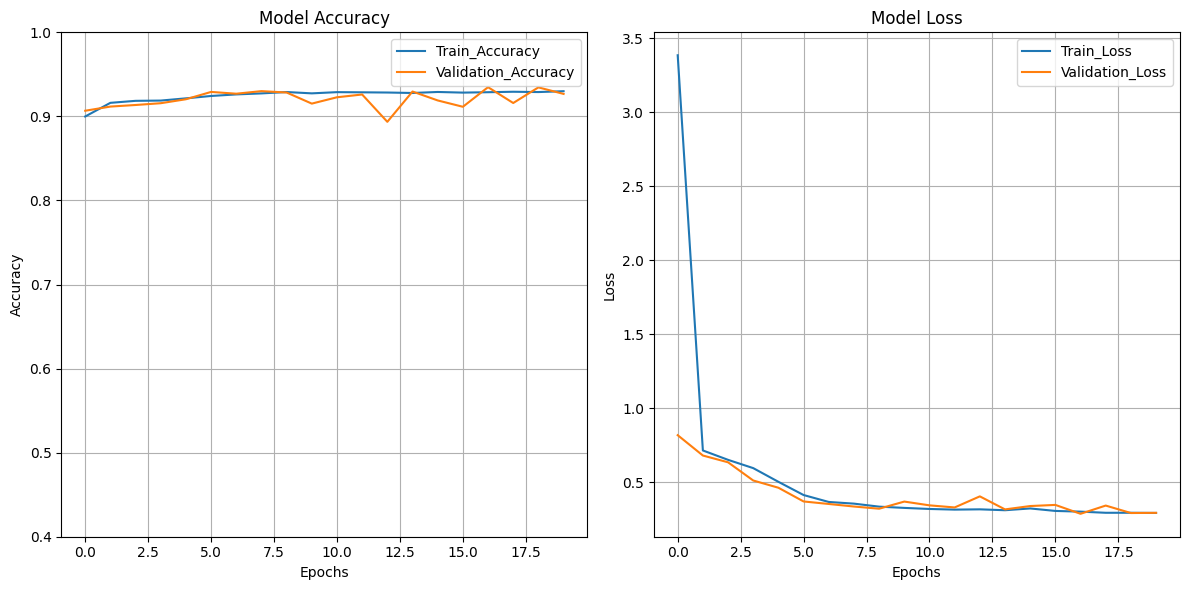

In [ ]:
# plotting training and validation accuracy and loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axis(ymin=0.4, ymax=1)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train_Accuracy', 'Validation_Accuracy'])
plt.tight_layout()
plt.grid()

# plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train_Loss', 'Validation_Loss'])
plt.tight_layout()
plt.grid()

plt.show()

In [ ]:
# evaluate the model

# parameters
testing_file_path = '../datasets/testing/test_set_1_1_CLASH2013_paper.tsv'

# load the testing dataset
print("----- <Loading Testing Dataset> -----")
df_test = pd.read_csv(testing_file_path, sep='\t')
print("----- <Dataset Loaded Successfully> -----\n")

# print the dataset shape and first few rows
print(f"Testing Dataset shape: {df_test.shape}")
print(f"First few rows of the dataset:\n{df_test.head()}\n")

# encode the testing data
print("----- <Encoding Data> -----")
encoded_testing_data, testing_labels = encode_dataset(df_test, "miRNA")         # encode_dataset(df_test, "noncodingRNA")
print("----- <Testing Data Encoded Successfully> -----")
print("----- <Successfully Encoded Data> -----\n")

print("----- <Evaluating Model> -----")
test_loss, test_accuracy = model.evaluate(encoded_testing_data, testing_labels)

# get predictions
predictions = model.predict(encoded_testing_data)
roc_auc = roc_auc_score(testing_labels, predictions)
print("----- <Model Evaluated Successfully> -----\n")

# display results
print(f"Test loss: {round(test_loss, 4)}\nTest accuracy: {round(test_accuracy, 4)} - {round(test_accuracy, 4) * 100}%")
print(f"Area Under Curve: {round(roc_auc, 4)}")


#### Saving Model

In [ ]:
# save the model
print("----- <Saving Model> -----")
model.save("miRBind_ResNet.keras")
print("----- <Model Saved Successfully> -----\n")